# **Title: Predicting Cardiovascular Disease Risk from Clinical Data**

# **1. Problem Statement:**

Cardiovascular diseases (CVDs) are leading in the death ranks globally, thus, they cause more than 17 million deaths annually. Early detection of people at risk allows interventions to be done timely and thus greatly improves outcomes. This project seeks to create a data-driven base with a capacity to predict the probability of a heart condition using structured clinical and lifestyle data including age, blood pressure, cholesterol, BMI, smoking, and others.

In effect, by undertaking data cleaning and exploratory analysis here we get this dataset ready for predictive modeling which can help health professionals to make early decisions.

# **2. Data Sources (Importing Libraries / Loading DataSet / Preview)**

In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("cleaned_cardiovascular_disease_dataset.csv")
print("Initial shape:", df.shape)

Initial shape: (62099, 14)


2.1 - Dataset Information

In [325]:
df.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
2901,16093,NaN,168,65.0,120,80,1,1,0,0,1,0,44,23.0
7481,21815,NaN,169,83.0,110,70,1,1,0,0,1,0,59,29.1
55955,18804,NaN,164,85.0,120,80,2,1,0,0,1,0,51,31.6
30434,19766,NaN,169,75.0,120,80,1,1,0,0,1,0,54,26.3
38087,15886,NaN,172,80.0,120,80,1,1,1,0,1,0,43,27.0


In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62099 entries, 0 to 62098
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62099 non-null  int64  
 1   gender       0 non-null      float64
 2   height       62099 non-null  int64  
 3   weight       62099 non-null  float64
 4   ap_hi        62099 non-null  int64  
 5   ap_lo        62099 non-null  int64  
 6   cholesterol  62099 non-null  int64  
 7   gluc         62099 non-null  int64  
 8   smoke        62099 non-null  int64  
 9   alco         62099 non-null  int64  
 10  active       62099 non-null  int64  
 11  cardio       62099 non-null  int64  
 12  age_years    62099 non-null  int64  
 13  bmi          62099 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 6.6 MB


In [327]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,62099.0,19480.108520,2460.910303,10859.0,17692.0,19710.0,21332.0,23713.0
gender,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,62099.0,164.709367,7.762841,120.0,160.0,165.0,170.0,207.0
weight,62099.0,73.015659,12.371136,28.0,65.0,71.0,80.0,135.0
ap_hi,62099.0,126.329764,14.266227,90.0,120.0,120.0,140.0,170.0
ap_lo,62099.0,81.653424,7.663341,65.0,80.0,80.0,90.0,105.0
cholesterol,62099.0,1.354386,0.672306,1.0,1.0,1.0,1.0,3.0
gluc,62099.0,1.219231,0.566255,1.0,1.0,1.0,1.0,3.0
smoke,62099.0,0.088923,0.284634,0.0,0.0,0.0,0.0,1.0
alco,62099.0,0.053060,0.224156,0.0,0.0,0.0,0.0,1.0


**3. Data Cleaning / Processing (8 Unique Steps)**

**3.1: Check and Remove Duplicates**

In [328]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)


After removing duplicates: (62099, 14)


There are no duplicates

**3.2: Check and Handle Missing/Null Values**

In [329]:
df.isnull().sum()

,0
age,0
gender,62099
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


The dataset has no null values

**3.3: Convert Age from Days to Years**

In [330]:
df['age_years'] = (df['age'] / 365).astype(int)

The age column is in days. We convert it to years for better interpretation.

**3.4: Create BMI Column**

In [331]:
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['bmi'] = df['bmi'].round(1)

BMI is an important clinical metric and isn't explicitly provided.So, we have created the BMI using weight and height

**3.5: Fix Invalid Blood Pressure Readings**

In [332]:
df = df[df['ap_lo'] <= df['ap_hi']]


Systolic BP (ap_hi) should always be higher than diastolic (ap_lo). Any violations are removed.

**3.6: Outliers Vizualiation and Removal**

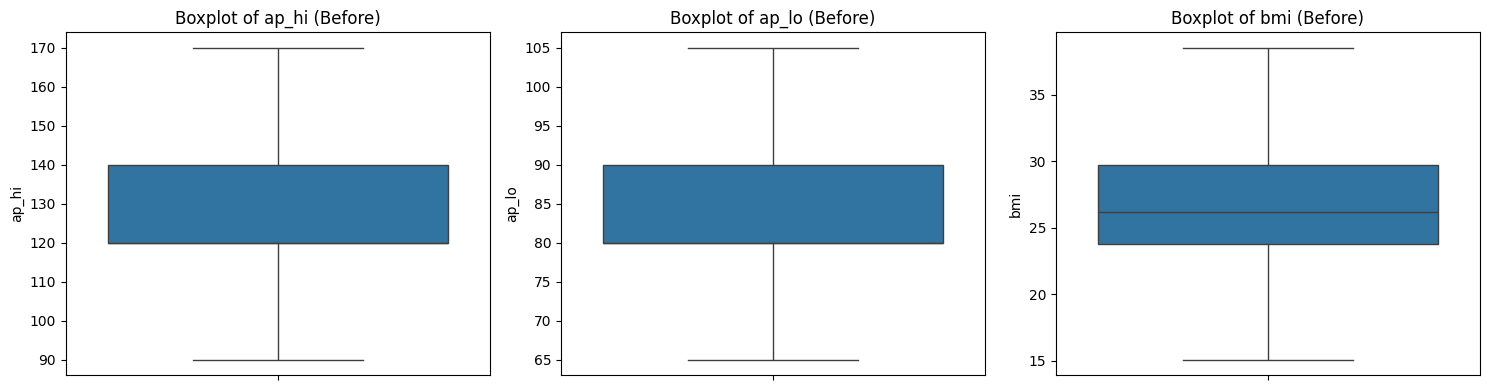

In [333]:
# Boxplots of outliers
features = ['ap_hi', 'ap_lo', 'bmi']

plt.figure(figsize=(15, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col} (Before)")
plt.tight_layout()
plt.show()

In [334]:
# function to remove outliers using IQR (INTER QUARTILE RANGE)
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

for col in features:
    df = remove_outliers_iqr(df, col)

print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (62099, 14)


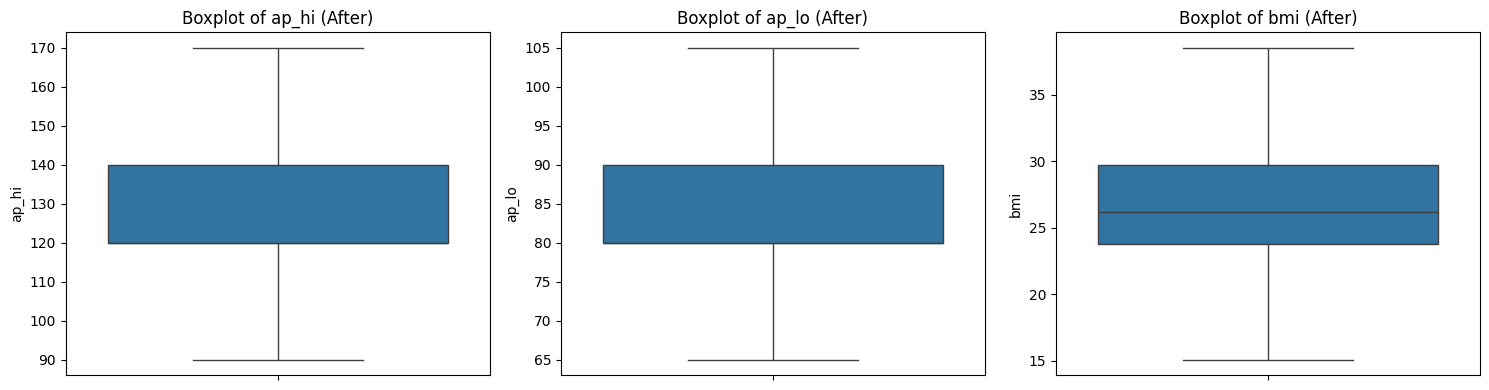

In [335]:
# Boxplots after removing outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col} (After)")
plt.tight_layout()
plt.show()


**3.7: Normalize Gender Column**

In [336]:
#Initial gender: male = 2 , female = 1
df['gender'] = df['gender'].map({1: 0, 2: 1})


Converting categorical codes (2,1) = (Male , Female) to Binaly codes (Male = 1,Female = 0) to improves analysis and model training.

**3.8 Encode Categorical Columns for ML Readiness**

In [337]:
df_encoded = pd.get_dummies(df, columns=['gender', 'cholesterol', 'gluc'], drop_first=True)


Convert categorical variables into binary (one-hot encoded) form for modeling.

**Saving the cleaned Data-Set**

In [338]:
df.to_csv('cleaned_cardiovascular_disease_dataset.csv', index=False)

In [339]:
df.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
30412,21756,NaN,154,70.0,120,70,2,2,0,0,1,1,59,29.5
42337,19757,NaN,154,64.0,130,80,2,1,0,0,1,0,54,27.0
10581,20499,NaN,175,64.0,150,100,3,3,1,0,1,0,56,20.9
8936,20572,NaN,168,73.0,130,90,1,1,0,0,1,1,56,25.9
5610,18045,NaN,168,56.0,120,80,1,1,1,1,1,0,49,19.8


# **4: EDA - (Exploratory Data Analysis)**

**4.1. Age Distribution using histplot**

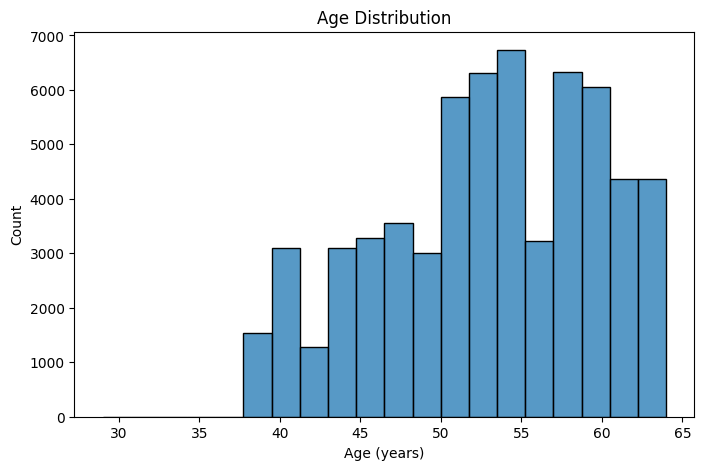

In [340]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age_years', bins=20)
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.show()

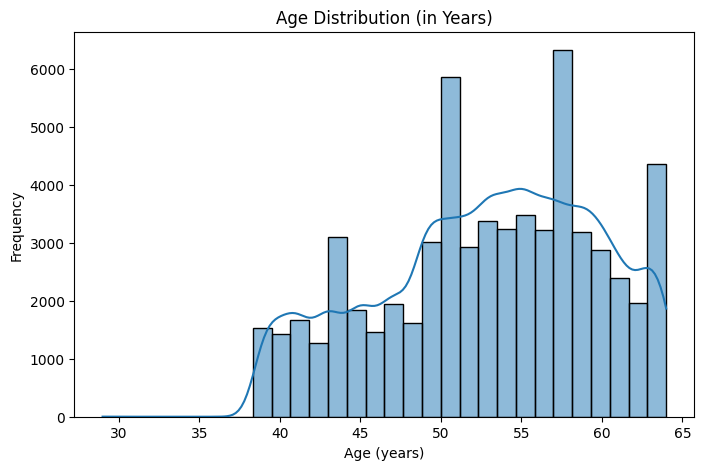

In [341]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title('Age Distribution (in Years)')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()


**4.2. Gender Distribution using countplot**

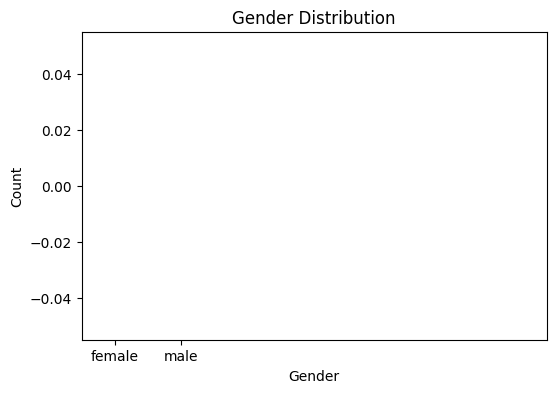

In [342]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks([1, 0], ['male', 'female'])
plt.show()

**4.3. Systolic Blood Pressure by Disease Status using violinplot**

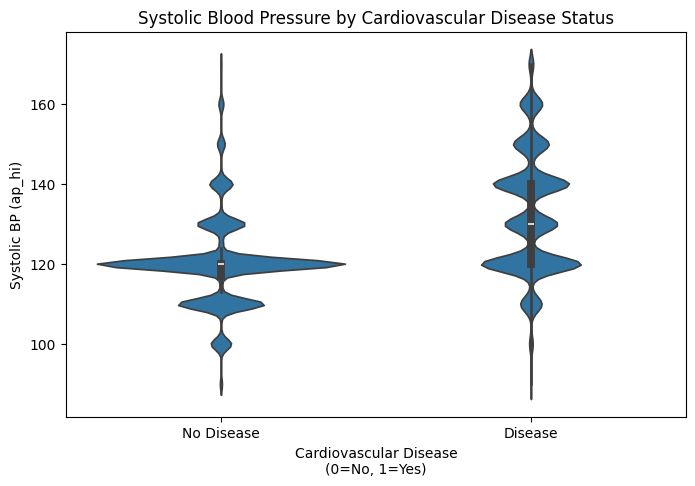

In [343]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='cardio', y='ap_hi')
plt.title('Systolic Blood Pressure by Cardiovascular Disease Status')
plt.xlabel('Cardiovascular Disease\n(0=No, 1=Yes)')
plt.ylabel('Systolic BP (ap_hi)')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.show()


**4.4. Correlation Heatmap**

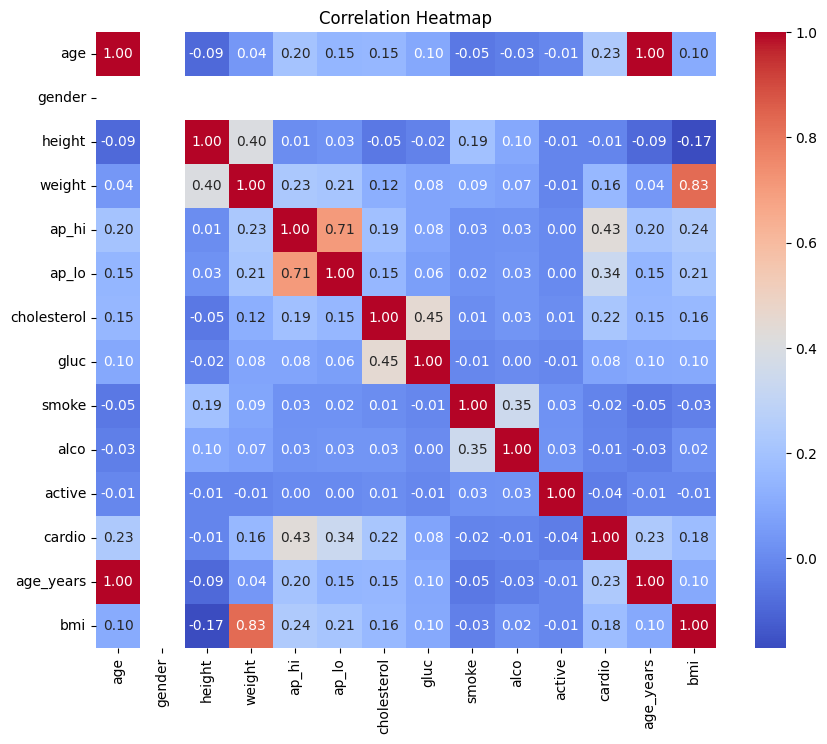

In [344]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
plt.close()


**4.5. BMI vs Age by Disease Status (Scatterplot)**

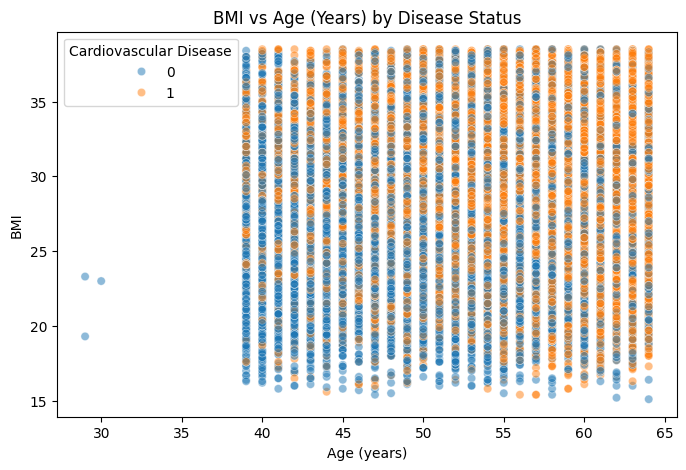

In [345]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age_years', y='bmi', hue='cardio', alpha=0.5)
plt.title('BMI vs Age (Years) by Disease Status')
plt.xlabel('Age (years)')
plt.ylabel('BMI')
plt.legend(title='Cardiovascular Disease')
plt.show()

4.6 Cholesterol Level vs Cardiovascular Disease (Bar Plot)

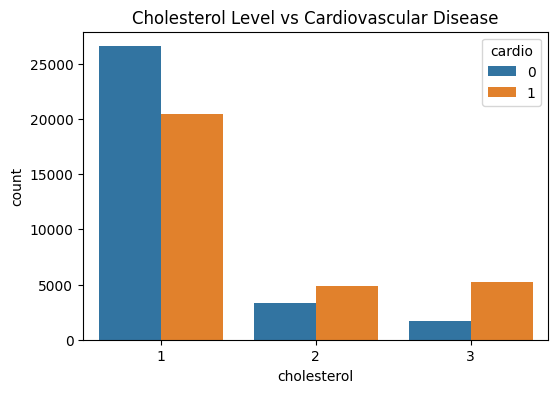

In [346]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='cholesterol', hue='cardio')
plt.title("Cholesterol Level vs Cardiovascular Disease")
plt.show()
plt.close()


**4.7. Most Frequent Systolic BP Values (Bar Plot)**

/tmp/ipython-input-347-3868572765.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ap_hi.index, y=top_ap_hi.values, palette='Blues_d')


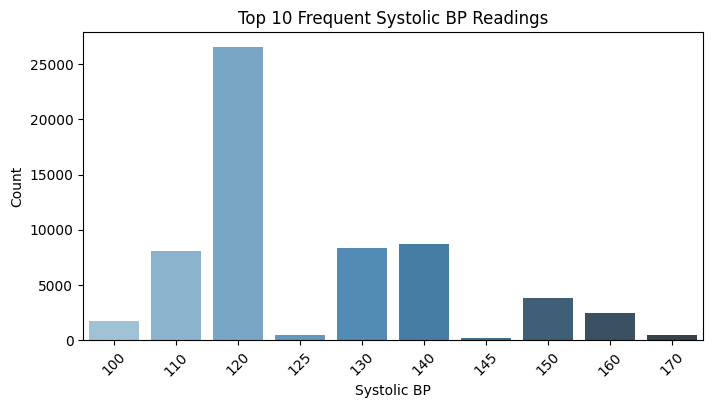

In [347]:
plt.figure(figsize=(8, 4))
top_ap_hi = df['ap_hi'].value_counts().nlargest(10)
sns.barplot(x=top_ap_hi.index, y=top_ap_hi.values, palette='Blues_d')
plt.title('Top 10 Frequent Systolic BP Readings')
plt.xlabel('Systolic BP')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**4.8. Smoking vs Disease Presence (Countplot)**

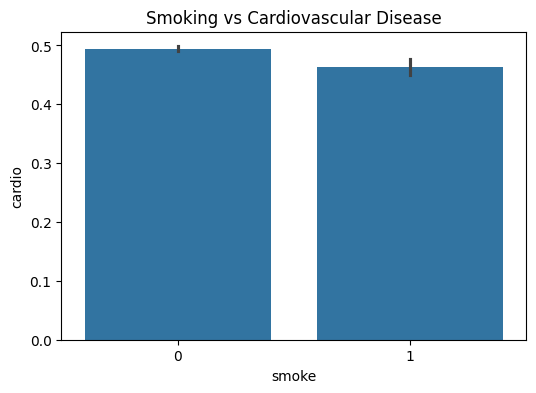

In [348]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='smoke', y='cardio')
plt.title("Smoking vs Cardiovascular Disease")
plt.show()
plt.close()

**4.9 Systolic Blood Pressure by Cardiovascular Disease Status**

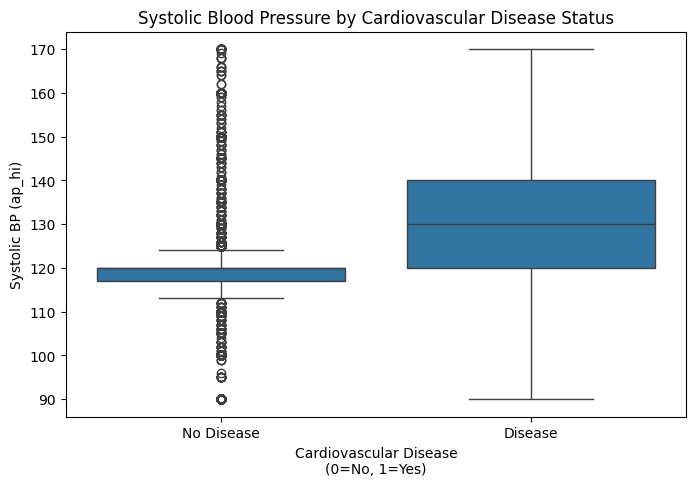

In [349]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cardio', y='ap_hi')
plt.title('Systolic Blood Pressure by Cardiovascular Disease Status')
plt.xlabel('Cardiovascular Disease\n(0=No, 1=Yes)')
plt.ylabel('Systolic BP (ap_hi)')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.show()

**4.10 Glucose Level vs Cardiovascular Disease**

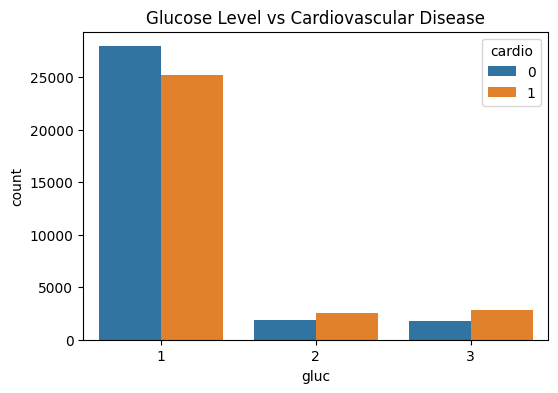

In [350]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gluc', hue='cardio')
plt.title("Glucose Level vs Cardiovascular Disease")
plt.show()
plt.close()

### **Other Important Exploratory Data Analysis**

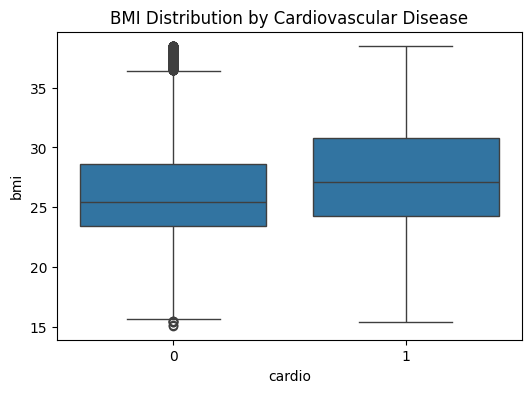

In [351]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='cardio', y='bmi')
plt.title("BMI Distribution by Cardiovascular Disease")
plt.show()
plt.close()

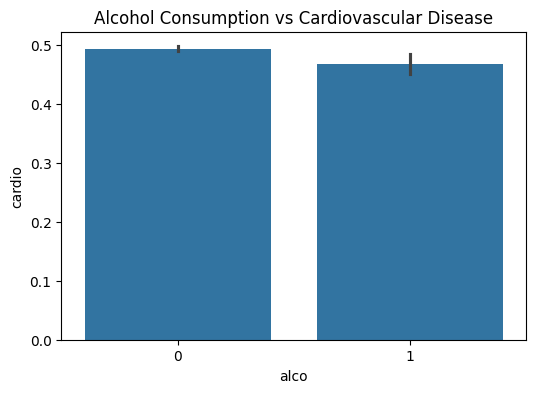

In [352]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='alco', y='cardio')
plt.title("Alcohol Consumption vs Cardiovascular Disease")
plt.show()
plt.close()

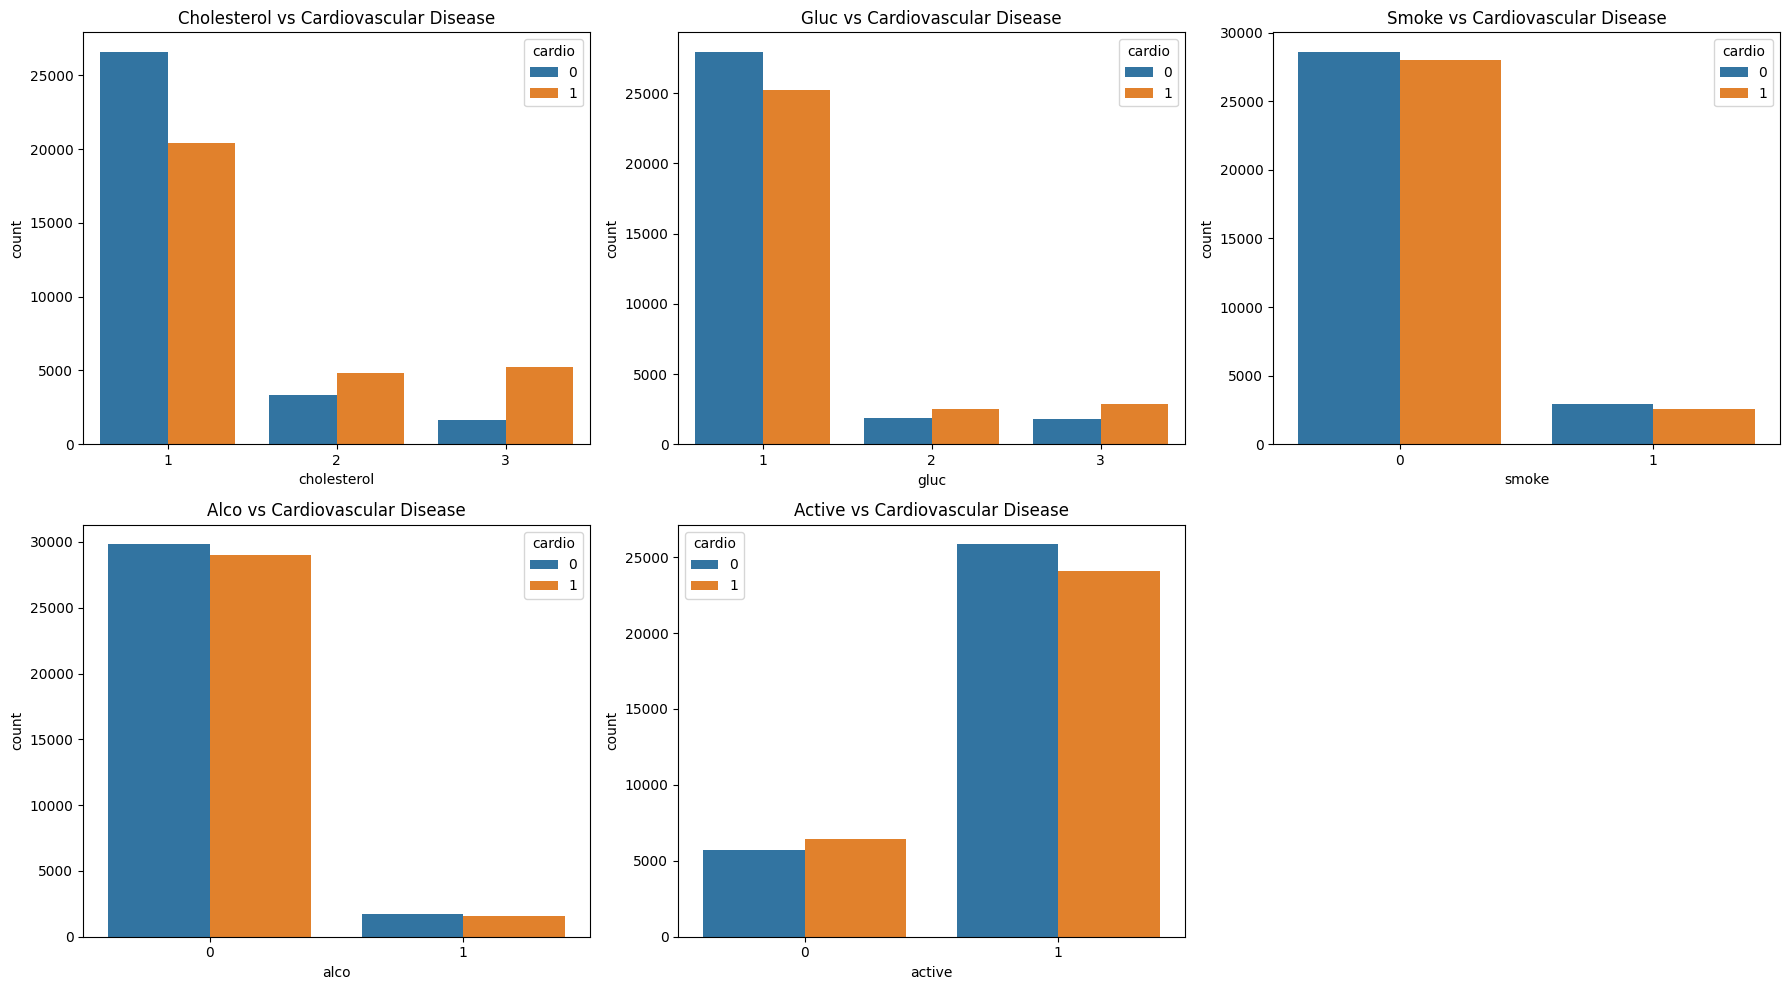

In [353]:

categorical_features = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, hue='cardio', ax=axes[i])
    axes[i].set_title(f'{col.capitalize()} vs Cardiovascular Disease')

for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()

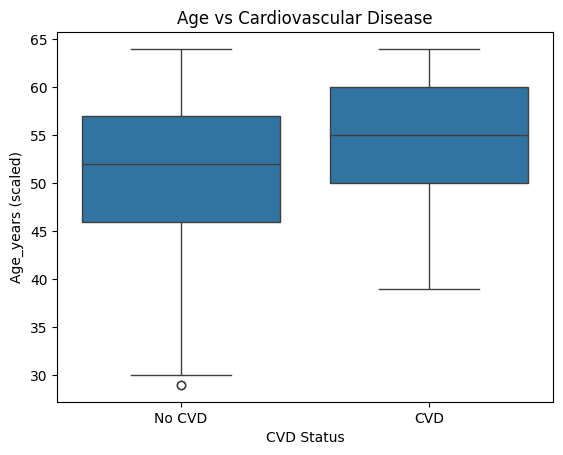

In [354]:
sns.boxplot(x='cardio', y='age_years', data=df)
plt.title("Age vs Cardiovascular Disease")
plt.xlabel("CVD Status")
plt.ylabel("Age_years (scaled)")
plt.xticks([0, 1], ['No CVD', 'CVD'])
plt.show()


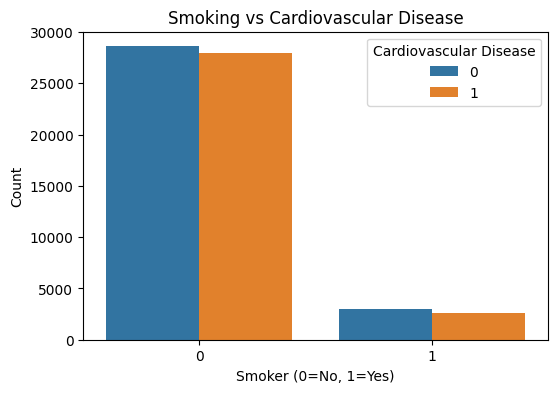

In [355]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='smoke', hue='cardio')
plt.title('Smoking vs Cardiovascular Disease')
plt.xlabel('Smoker (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Cardiovascular Disease')
plt.show()

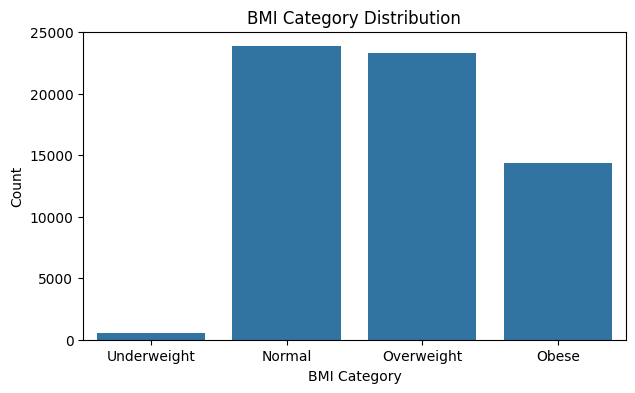

In [356]:
bins = [0, 18.5, 25, 30, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels)

plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='bmi_category', order=labels)
plt.title('BMI Category Distribution')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()


df.drop('bmi_category',axis=1,inplace=True)

# 5. Machine Learning (ML), Statistical modeling, and MapReduce (MR)

5.1 Checking Cleaned Data

In [357]:
print("Latest Shape:", df.shape)

Latest Shape: (62099, 14)


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62099 entries, 0 to 62098
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62099 non-null  int64  
 1   gender       0 non-null      float64
 2   height       62099 non-null  int64  
 3   weight       62099 non-null  float64
 4   ap_hi        62099 non-null  int64  
 5   ap_lo        62099 non-null  int64  
 6   cholesterol  62099 non-null  int64  
 7   gluc         62099 non-null  int64  
 8   smoke        62099 non-null  int64  
 9   alco         62099 non-null  int64  
 10  active       62099 non-null  int64  
 11  cardio       62099 non-null  int64  
 12  age_years    62099 non-null  int64  
 13  bmi          62099 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 6.6 MB


In [359]:
df.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
17768,21252,NaN,169,72.0,120,90,1,1,0,0,1,0,58,25.2
37473,20515,NaN,158,83.0,110,80,1,1,0,1,1,0,56,33.2
14284,14876,NaN,169,63.0,120,80,1,1,0,0,1,0,40,22.1
55043,22014,NaN,161,85.0,110,70,1,1,0,0,1,0,60,32.8
23324,22595,NaN,166,53.0,120,80,1,1,0,0,1,1,61,19.2


5.2 Class Imbalance Ratio Check

In [360]:
target_counts = df['cardio'].value_counts()

target_percentages = df['cardio'].value_counts(normalize=True) * 100

minority = target_counts.min()
majority = target_counts.max()
imbalance_ratio = round(minority / majority, 3)

print("Target Distribution:\n", target_counts)

print("\nTarget Percentages:\n", target_percentages)

print(f"\nImbalance Ratio (minority/majority): {imbalance_ratio}")


Target Distribution:
 cardio
0    31563
1    30536
Name: count, dtype: int64

Target Percentages:
 cardio
0    50.826905
1    49.173095
Name: proportion, dtype: float64

Imbalance Ratio (minority/majority): 0.967


Our data set is well Balanced.

5.3 Importing Libraries for Model Training

In [361]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, mean_squared_error

5.4 Spliting the data Trainig and Testing, Scaling , Normalize features

In [362]:
# Features and target
X = df.drop(["cardio", "gender"], axis=1)
y = df["cardio"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Selected Features:\n", X.columns.tolist())
print("Scaled Sample:\n", X.head())

Selected Features:
 ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi']
Scaled Sample:
      age  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0  18393     168    62.0    110     80            1     1      0     0   
1  20228     156    85.0    140     90            3     1      0     0   
2  18857     165    64.0    130     70            3     1      0     0   
3  17623     169    82.0    150    100            1     1      0     0   
4  21914     151    67.0    120     80            2     2      0     0   

   active  age_years   bmi  
0       1         50  22.0  
1       1         55  34.9  
2       0         51  23.5  
3       1         48  28.7  
4       0         60  29.4  


5.5 Function Definition for the Evaluate Model

In [363]:
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report
)

def evaluate_model(y_true, y_pred, y_probs, model_name):
    print(f"\n=== {model_name} Evaluation ===")

    # Print Metrics
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix and ROC data
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Disease", "Disease"],
                yticklabels=["No Disease", "Disease"],
                ax=axes[0])
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # ROC Curve Plot
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.4f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    axes[1].set_title(f"{model_name} - ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid()

    plt.tight_layout()
    plt.show()



 5.6 Logistic Regression


=== Logistic Regression Evaluation ===
Accuracy : 0.7178743961352657
Precision: 0.7378971255673222
Recall   : 0.6481727574750831
F1 Score : 0.6901308807923594

Classification Report:
              precision    recall  f1-score   support

           0     0.7030    0.7834    0.7411      6400
           1     0.7379    0.6482    0.6901      6020

    accuracy                         0.7179     12420
   macro avg     0.7205    0.7158    0.7156     12420
weighted avg     0.7199    0.7179    0.7164     12420



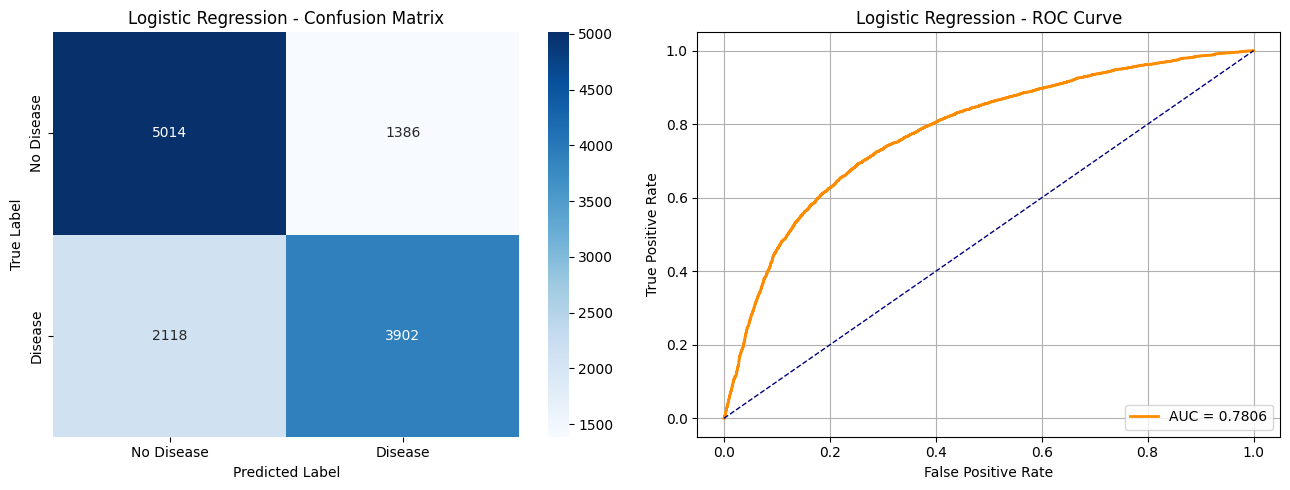

In [364]:
from sklearn.linear_model import LogisticRegression

# Features and target
X = df.drop(["cardio", "gender"], axis=1)
y = df["cardio"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
y_probs = logreg.predict_proba(X_test_scaled)[:, 1]
evaluate_model(y_test, y_pred, y_probs, "Logistic Regression")

5.7 K-Nearest Neighbors


=== K-Nearest Neighbors Evaluation ===
Accuracy : 0.6799516908212561
Precision: 0.6726904239148792
Recall   : 0.6616279069767442
F1 Score : 0.6671133070932083

Classification Report:
              precision    recall  f1-score   support

           0     0.6866    0.6972    0.6918      6400
           1     0.6727    0.6616    0.6671      6020

    accuracy                         0.6800     12420
   macro avg     0.6796    0.6794    0.6795     12420
weighted avg     0.6798    0.6800    0.6799     12420



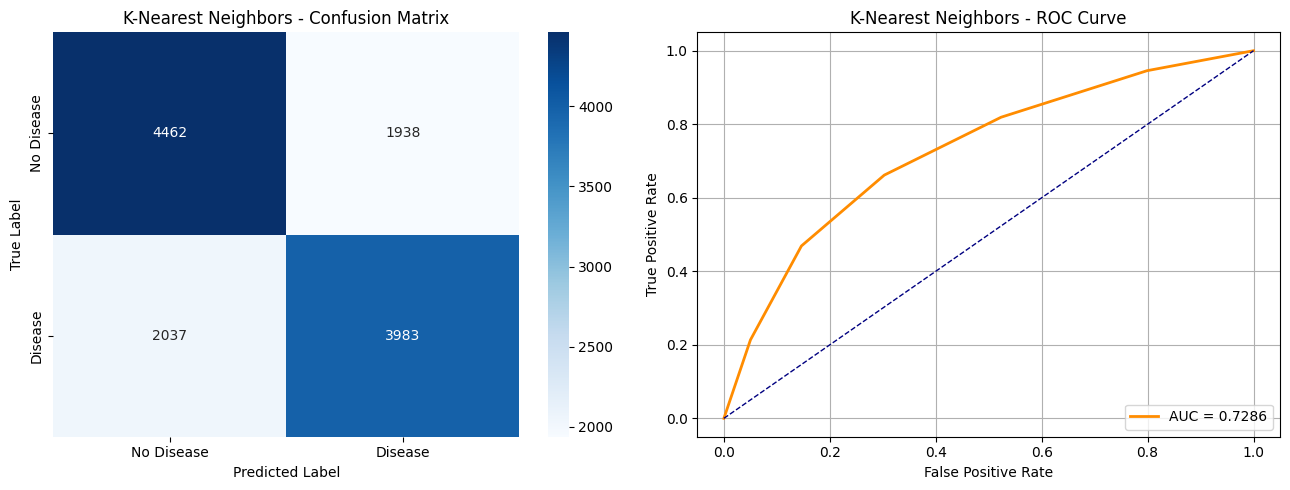

In [365]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
y_probs = knn.predict_proba(X_test_scaled)[:, 1]
evaluate_model(y_test, y_pred, y_probs, "K-Nearest Neighbors")


5.8 Naive Bayes


=== Naive Bayes Evaluation ===
Accuracy : 0.706280193236715
Precision: 0.7341097512830635
Recall   : 0.6177740863787375
F1 Score : 0.670936316074328

Classification Report:
              precision    recall  f1-score   support

           0     0.6871    0.7895    0.7348      6400
           1     0.7341    0.6178    0.6709      6020

    accuracy                         0.7063     12420
   macro avg     0.7106    0.7037    0.7029     12420
weighted avg     0.7099    0.7063    0.7038     12420



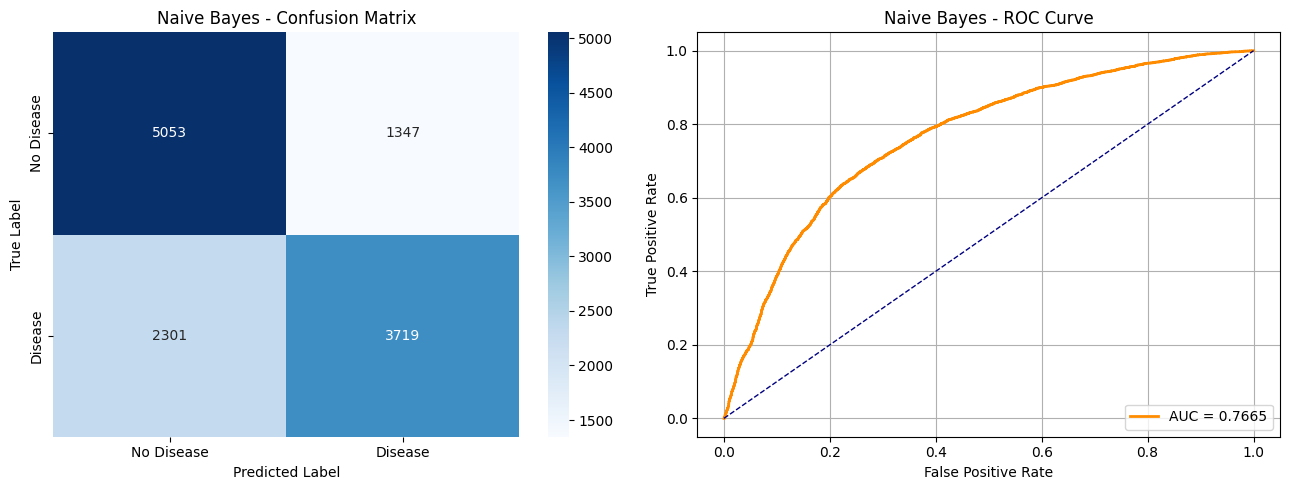

In [366]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
y_probs = nb.predict_proba(X_test_scaled)[:, 1]
evaluate_model(y_test, y_pred, y_probs, "Naive Bayes")


5.9 Random Forest


=== Random Forest Evaluation ===
Accuracy : 0.7003220611916264
Precision: 0.6975584594222833
Recall   : 0.6739202657807309
F1 Score : 0.6855356539371409

Classification Report:
              precision    recall  f1-score   support

           0     0.7028    0.7252    0.7138      6400
           1     0.6976    0.6739    0.6855      6020

    accuracy                         0.7003     12420
   macro avg     0.7002    0.6995    0.6997     12420
weighted avg     0.7002    0.7003    0.7001     12420



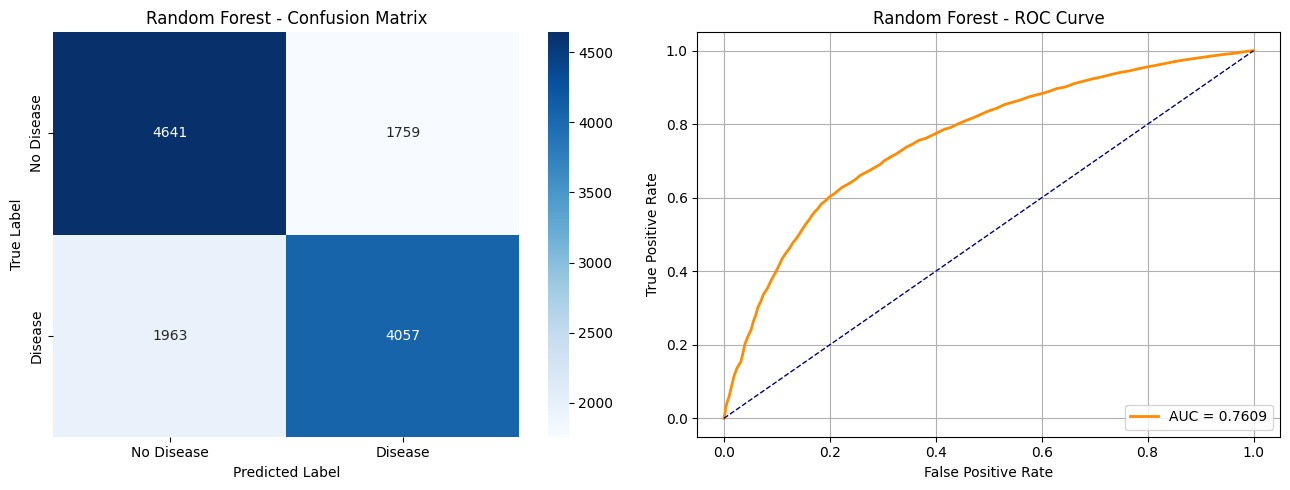

In [367]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_probs, "Random Forest")


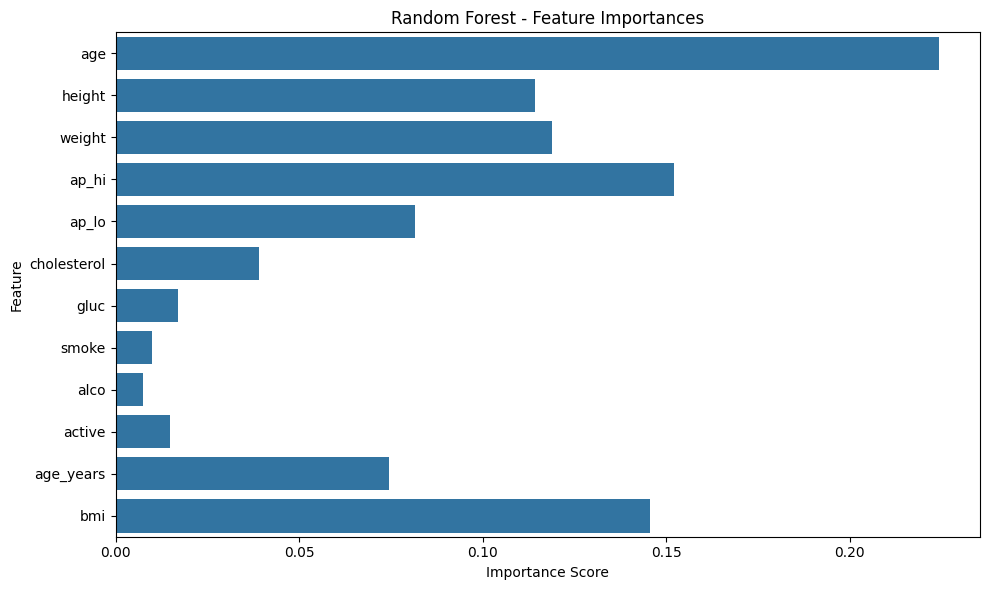

In [368]:
# Feature importances
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Random Forest - Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


 5.10 XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:48:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Evaluation ===
Accuracy : 0.7181159420289855
Precision: 0.7296262534184138
Recall   : 0.6647840531561462
F1 Score : 0.6956975228161669

Classification Report:
              precision    recall  f1-score   support

           0     0.7090    0.7683    0.7375      6400
           1     0.7296    0.6648    0.6957      6020

    accuracy                         0.7181     12420
   macro avg     0.7193    0.7165    0.7166     12420
weighted avg     0.7190    0.7181    0.7172     12420



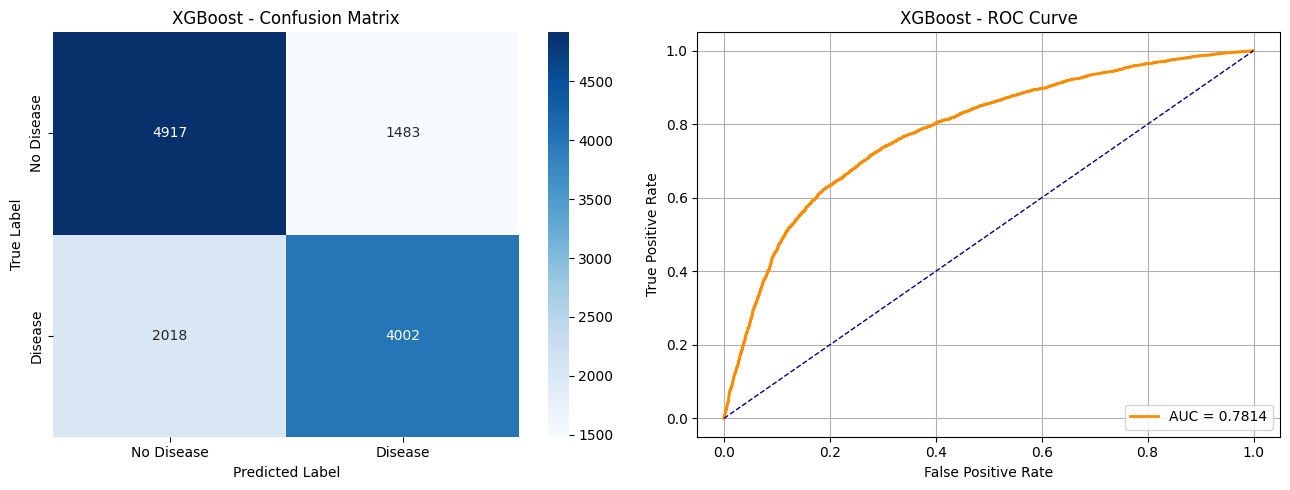

In [369]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_probs, "XGBoost")


<Figure size 1000x600 with 0 Axes>

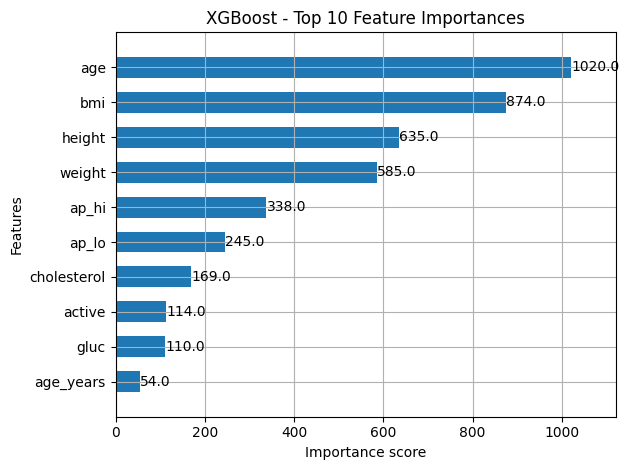

In [370]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=10, importance_type='weight', height=0.6)
plt.title("XGBoost - Top 10 Feature Importances")
plt.tight_layout()
plt.show()